In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
df = pd.read_csv(r"C:\Users\shilp\Downloads\Netflix Dataset.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Show_Id       7789 non-null   object
 1   Category      7789 non-null   object
 2   Title         7789 non-null   object
 3   Director      5401 non-null   object
 4   Cast          7071 non-null   object
 5   Country       7282 non-null   object
 6   Release_Date  7779 non-null   object
 7   Rating        7782 non-null   object
 8   Duration      7789 non-null   object
 9   Type          7789 non-null   object
 10  Description   7789 non-null   object
dtypes: object(11)
memory usage: 669.5+ KB


In [7]:
df.head()

,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [11]:
df.shape

(7789, 11)

In [13]:
# Cleaning & Preprocessing

In [15]:
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
# If your sheet had 'Case' as typo, rename:
if 'case' in df.columns and 'cast' not in df.columns:
    df = df.rename(columns={'case':'cast'})

# 3. Parse release date and extract year
# try common formats; coerce errors
df['release_date_parsed'] = pd.to_datetime(df['release_date'], errors='coerce')
# If release_date only has year, fallback:
df['year'] = df['release_date_parsed'].dt.year
# If still NaN, try extracting 4-digit year from string
missing_year_mask = df['year'].isna()
df.loc[missing_year_mask, 'year'] = df.loc[missing_year_mask, 'release_date'].str.extract(r'(\d{4})').astype(float)

# convert to int where possible
df['year'] = df['year'].astype('Int64')  # nullable integer

In [17]:
# Clean text columns & handle multi-valued fields

In [19]:
# trim strings
for col in ['title', 'director', 'cast', 'country', 'rating', 'type', 'description', 'category', 'duration']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().replace({'nan': None})

# Many fields like country or type (genres) may have comma-separated values.
# Create helper to explode multi-valued columns for analysis.
def split_explode(df, col, sep=','):
    """Return exploded DataFrame for a multi-valued column."""
    s = df[col].fillna('').astype(str).str.split(sep)
    s = s.apply(lambda x: [i.strip() for i in x if i and i.strip()!=''])
    exploded = df.loc[s.index].copy()
    exploded = exploded.assign(**{col: s})
    exploded = exploded.explode(col)
    exploded[col] = exploded[col].replace('', np.nan)
    return exploded

# Example: exploded genres and countries
df_genres = split_explode(df, 'type')
df_countries = split_explode(df, 'country')


In [21]:
# Objective 1 — Movies vs TV Shows over the years

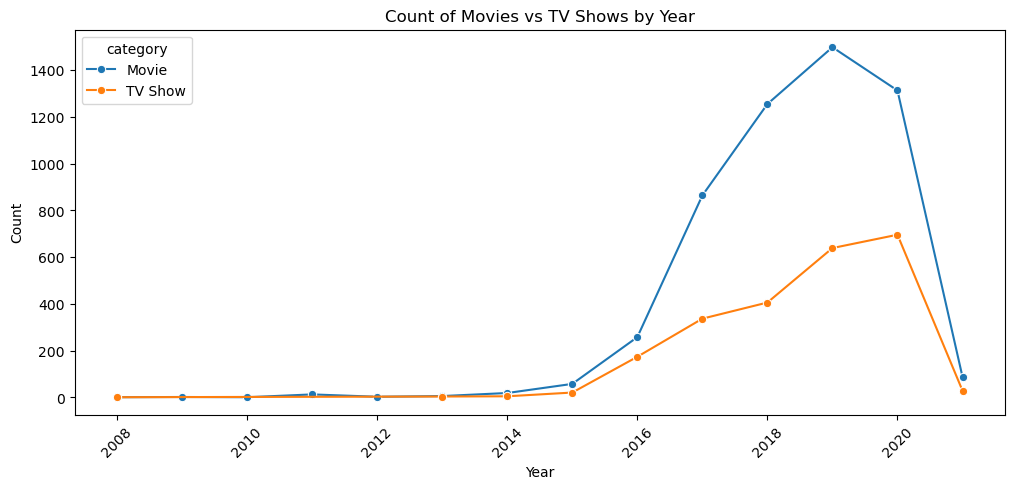

In [23]:
# Clean type/category for movie/tv - assume column 'category' or maybe 'category' is Movie/TV?
# The dataset you described has a 'Category' — check unique values
df['category'].value_counts(dropna=False)

# Trend by year
trend = df.groupby(['year', 'category']).size().reset_index(name='count')
# Plot (matplotlib/seaborn)
plt.figure(figsize=(12,5))
sns.lineplot(data=trend, x='year', y='count', hue='category', marker='o')
plt.title('Count of Movies vs TV Shows by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [25]:
# Objective 2 — Genres (Type) popularity & trend

type
International Movies        2437
Dramas                      2108
Comedies                    1472
International TV Shows      1199
Documentaries                786
Action & Adventure           721
TV Dramas                    704
Independent Movies           675
Children & Family Movies     532
Romantic Movies              531
TV Comedies                  525
Thrillers                    492
Crime TV Shows               427
Kids' TV                     414
Docuseries                   353
Romantic TV Shows            333
Stand-Up Comedy              329
Music & Musicals             321
Horror Movies                312
British TV Shows             232
Name: count, dtype: int64


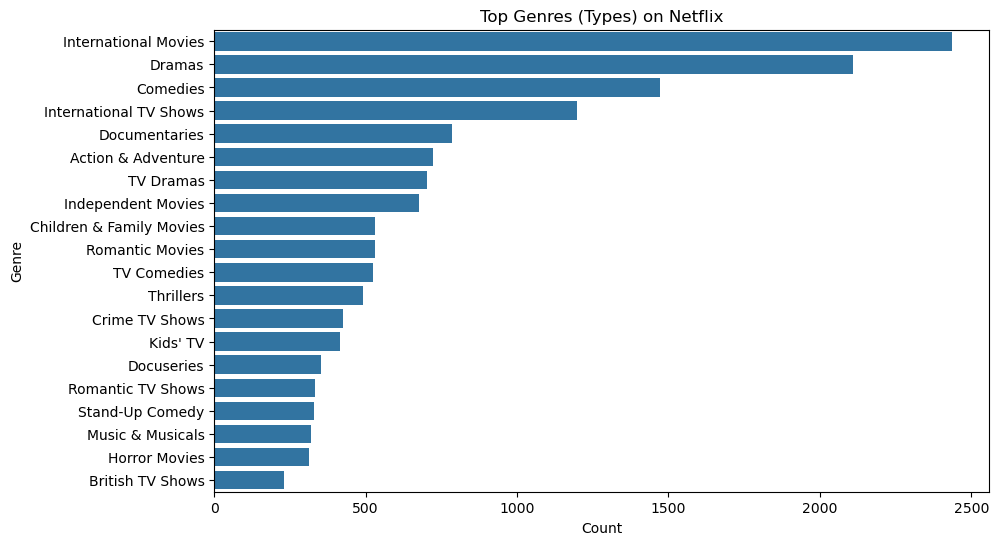

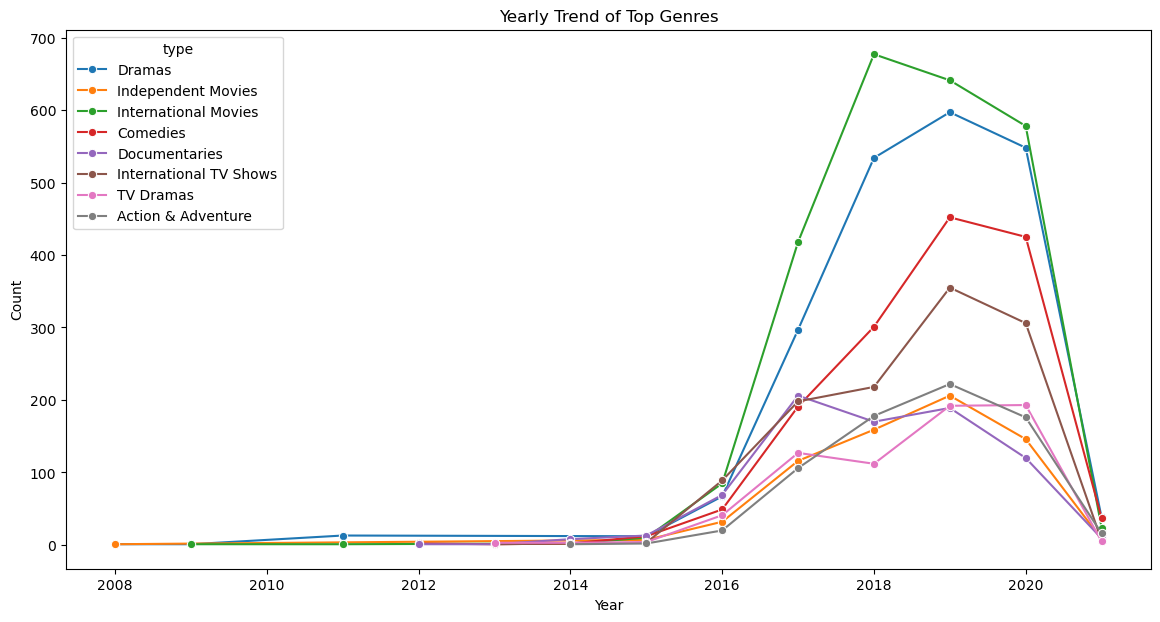

In [27]:
# Top genres overall
top_genres = df_genres['type'].value_counts().head(20)
print(top_genres)

# Plot bar of top genres
plt.figure(figsize=(10,6))
sns.barplot(y=top_genres.index, x=top_genres.values)
plt.title('Top Genres (Types) on Netflix')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

# Genre trends across years: (explode done above = df_genres)
genre_trend = (df_genres
               .dropna(subset=['year','type'])
               .groupby(['year','type']).size().reset_index(name='count'))

# For clarity, pick top N genres
top_n = top_genres.index[:8].tolist()
genre_trend_top = genre_trend[genre_trend['type'].isin(top_n)]

plt.figure(figsize=(14,7))
sns.lineplot(data=genre_trend_top, x='year', y='count', hue='type', marker='o')
plt.title('Yearly Trend of Top Genres')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()
